# Mock-up of polymer repeat unit placement

## Define reference Primitive

### Atomistic primitives

In [1]:
from rdkit import Chem
from rdkit.Chem.AllChem import EmbedMolecule, CanonicalizeMol
from rdkit.Chem.Draw import IPythonConsole

import numpy as np

from mupt.chemistry.linkers import get_linker_and_bridgehead_idxs
from mupt.mupr.primitives import Primitive


def reference_primitive_atomistic(smiles : str) -> tuple[Primitive, float]:
    mol = Chem.MolFromSmiles(smiles)
    mol = Chem.AddHs(mol)
    err_code = EmbedMolecule(mol) # positions are determined here
    assert err_code == 0, f"Embedding failed with error code {err_code}"
    display(mol)

    conf = mol.GetConformer(0)
    CanonicalizeMol(mol)
    linker_coords : list[list[int]] = [
        list(conf.GetAtomPosition(linker_idx))
            for linker_idx, bh_idx in get_linker_and_bridgehead_idxs(mol)
    ]
    arr = np.array(linker_coords)
    del_x, del_y, del_z = np.ptp(arr, axis=0)

    return Primitive.from_rdkit(mol), del_x

### Ellipsoidal primitives

In [2]:
import numpy as np

from mupt.geometry.shapes import Ellipsoid
from mupt.mupr.primitives import Primitive
from mupt.mupr.ports import Port


def reference_primitive_ellipsoidal(
    semimajor : float,
    semiminor : float,
    bond_length : float, 
) -> tuple[Primitive, int]:
    prim_ref = Primitive(
        num_atoms=5,
        chemistry=None,
        shape=Ellipsoid.from_components(semimajor, semiminor, semiminor),
        # for now, settings Ports "straight forward and back" from poles; should choose some polar angle orientation to get more interesting linkages
        ports=(
            Port(
                linker=0,
                bridgehead=0,
                linker_flavor=0,
                linker_position=np.array([semimajor + bond_length/2, 0.0, 0.0]),
                bridgehead_position=np.array([semimajor, 0.0, 0.0]),
                orientator_position=np.array([semimajor, 1.0, 0.0]), # orientator parallel to z-axis makes XY-plane the dihedral plane
            ),
            Port(
                linker=1,
                bridgehead=1,
                linker_flavor=1,
                linker_position=np.array([-(semimajor + bond_length/2), 0.0, 0.0]),
                bridgehead_position=np.array([-semimajor, 0.0, 0.0]),
                orientator_position=np.array([-(semimajor), 1.0, 0.0]), # orientator parallel to z-axis makes XY-plane the dihedral plane
            ),
        )
    )

    return prim_ref, 2*semimajor + bond_length

## Obtain centers and orientations from black box (in this case, a random walk)

## Select TYPE of Primitive 

[21:50:03] UFFTYPER: Unrecognized atom type: *_ (3)
[21:50:03] UFFTYPER: Unrecognized atom type: *_ (13)


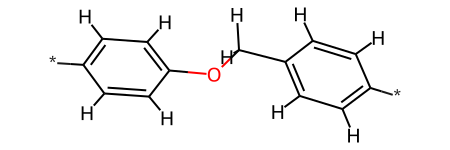

In [3]:
from enum import Enum, auto

class PrimitiveType(Enum):
    ALL_ATOM = auto()
    COARSE_GRAIN = auto()

# set what kind of behavior you want here!!
prim_type = PrimitiveType.ALL_ATOM
# prim_type = PrimitiveType.COARSE_GRAIN

# initialize reference primitive according to preference
if prim_type == PrimitiveType.ALL_ATOM:
    prim_ref, step_size = reference_primitive_atomistic('c1cc(*)ccc1OCc2ccc(*)cc2')
elif prim_type == PrimitiveType.COARSE_GRAIN:
    prim_ref, step_size = reference_primitive_ellipsoidal(semimajor=9.0, semiminor=4.0, bond_length=1.0)
else:
    raise ValueError('Invalid Primitive Type selected')


In [4]:
from typing import Generator, Optional
from scipy.spatial.transform import Rotation, RigidTransform

from mupt.geometry.random_walk import random_walk_jointed_chain
from mupt.geometry.transforms.linear import reflector


# setting this will cause adjacent steps to line up along Ports (similar to mBuild polymer),
# rather than following the steps of the random walk; this is currently for demo purposes only
align_ports : bool = False

# generate steps from random walk
# def alt(l1 : float, l2 : float) -> Generator[float, None, None]:
#     '''Alternating step size generator for random walks'''
#     while True:
#         yield l1
#         yield l2


# NOTE: the specifics of the implementation here are unimportant - just that you have a way to obtain centers and orientations
points = random_walk_jointed_chain(
    n_steps_max=50,
    step_size=step_size, # length of ellipsoid plus 2 halves of a bond on either end
    # step_size=alt(5.0, 10.0),
    clip_angle=np.pi*1/4, # maximum allowable angle between consecutive vectors
    starting_point=np.array([0, 0, 0], dtype=float),
)
steps = np.diff(points, axis=0)

# transform reference Primitive according to walk steps - process is uniform regardless of Shape definition
prims : list[Primitive] = []
prior_prim : Optional[Primitive] = None
for step_start, step_vector in zip(points[:-1], steps):
    unit_step_vector = step_vector / np.linalg.norm(step_vector)
    ## compute orientation rotation by aligning +x-axis unit vector with unit step in step direction
    ## done with Householder reflection for numerical stability / no angle calc, with a pre-reflection to preserve overall handedness
    ## pre-flection can be done in any plane which contains the x-axis, e.g. chosen the XZ-plane here (normal to +y-axis)
    R = reflector(np.array([1, 0, 0]) - unit_step_vector) @ reflector(np.array([0, 1, 0]))
    assert np.isclose(np.linalg.det(R), 1.0) # double-check this is a valid rotation matrix
    
    step_transform = RigidTransform.from_components(
        translation=step_start + step_vector/2, # midpoint of the step
        rotation=Rotation.from_matrix(R),
    )
    curr_prim = prim_ref.apply_rigid_transformation(step_transform) # this returns a NEW Primitive instance with the same contents, but spatially transformed
    
    if align_ports and (prior_prim is not None): # if this is not the first Primitive in the chain, also align to the neighboring Port of the prior Primitive
        curr_prim = curr_prim.apply_rigid_transformation(
            curr_prim.ports[-1].alignment_transform_to(prior_prim.ports[0]) 
        )
    prims.append(curr_prim)
    prior_prim = curr_prim

## 3) Visualize chain

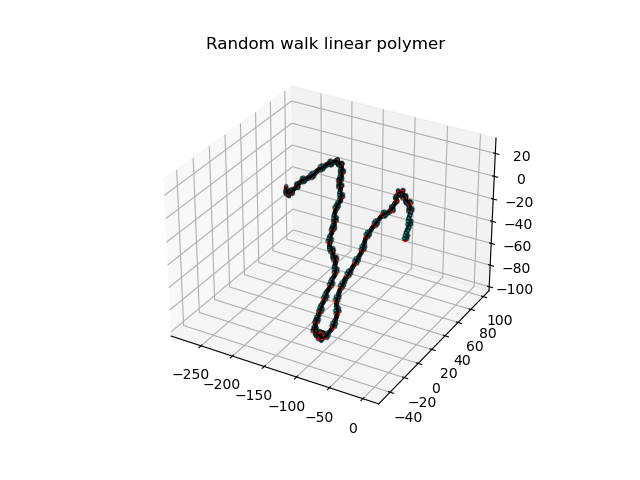

In [6]:
import matplotlib.pyplot as plt
%matplotlib ipympl
# %matplotlib notebook
from mupt.geometry.shapes import Ellipsoid, PointCloud


# display shapes
plt.close()
fig = plt.figure()
fig.canvas.header_visible = False

ax = fig.add_subplot(projection='3d')
ax.autoscale(enable=True)
ax.set_title(f'Random walk linear polymer {"(aligned along ports)" if align_ports else ""}')
    
# plot random walk steps (if needed)
if not align_ports:
    _ = ax.scatter(*points.T, color='r', marker='.')
    _ = ax.quiver(*points[:-1].T, *steps.T, arrow_length_ratio=0.1, color='k')

# plot Primitives in chain
for prim in prims:
    if isinstance(prim.shape, PointCloud):
        shape_points = prim.shape.positions
        _ = ax.scatter(*shape_points.T, fc='c', ec='k', marker='.', alpha=0.5)
    elif isinstance(prim.shape, Ellipsoid):
        shape_points = prim.shape.surface_mesh(20, 20)
        _ = ax.plot_surface(*shape_points.T, color='c', alpha=0.5)

    for port in prim.ports:
        ax.plot(*np.vstack([port.linker_position, port.bridgehead_position]).T, 'r--')
plt.show()

## Next Steps:
* ~~Forcing port alignment (correct angle + dihedral between residues)~~
* Topology - support for nested Primitive networks in place of explicit RDKIt-like chemistry
* "Coagulation" - combining primitives into single molecule object
* Export: writing to other tools' formats